In [1]:
"""
 Copyright (c) 2021-2024 D-Robotics Corporation

 Licensed under the Apache License, Version 2.0 (the "License");
 you may not use this file except in compliance with the License.
 You may obtain a copy of the License at

      http://www.apache.org/licenses/LICENSE-2.0

 Unless required by applicable law or agreed to in writing, software
 distributed under the License is distributed on an "AS IS" BASIS,
 WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 See the License for the specific language governing permissions and
 limitations under the License.
"""

'\n Copyright (c) 2021-2024 D-Robotics Corporation\n\n Licensed under the Apache License, Version 2.0 (the "License");\n you may not use this file except in compliance with the License.\n You may obtain a copy of the License at\n\n      http://www.apache.org/licenses/LICENSE-2.0\n\n Unless required by applicable law or agreed to in writing, software\n distributed under the License is distributed on an "AS IS" BASIS,\n WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.\n See the License for the specific language governing permissions and\n limitations under the License.\n'

In [2]:
!cat /proc/meminfo | grep Mem

MemTotal:        3304420 kB
MemFree:         1147660 kB
MemAvailable:    2214920 kB


In [3]:
# import necessary package
import numpy as np
import cv2
import pyclipper
import bpu_infer_lib
import matplotlib.pyplot as plt
import collections

In [4]:
# load image function
def load_image(img_path):
    """Load an image from a file path."""
    img = cv2.imread(img_path)
    if img is None:
       print(f"Image file '{img_path}' not found.")
    return img

In [5]:
# load image
model_path = 'model/en_PP-OCRv3_det_640x640_nv12.bin'
img_path = "data/paddleocr_test.jpg"
origin_img = load_image(img_path)

In [6]:
detection_model = bpu_infer_lib.Infer(False)
if not detection_model.load_model(model_path):
    print(f"Failed to load model from '{model_path}'.")
        
threshold = 0.5           # Threshold for binary classification
ratio_prime = 2.7         # Expansion ratio for the contour
input_size = (640, 640)   # Model input size

The model path is valid and points to a regular file.
[BPU_PLAT]BPU Platform Version(1.3.6)!
[HBRT] set log level as 0. version = 3.15.49.0
[DNN] Runtime version = 1.23.8_(3.15.49 HBRT)
[A][DNN][packed_model.cpp:247][Model](2024-09-17,07:25:22.660.936) [HorizonRT] The model builder version = 1.23.8
[W][DNN]bpu_model_info.cpp:491][Version](2024-09-17,07:25:22.671.499) Model: en_PP-OCRv3_det_infer-deploy_640x640_nv12. Inconsistency between the hbrt library version 3.15.49.0 and the model build version 3.15.54.0 detected, in order to ensure correct model results, it is recommended to use compilation tools and the BPU SDK from the same OpenExplorer package.


In [7]:
def get_bounding_boxes(dilated_polys, min_area):
    """Get bounding boxes from dilated polygons."""
    boxes_list = []
    for cnt in dilated_polys:
        if cv2.contourArea(cnt) < min_area:
            continue
        rect = cv2.minAreaRect(cnt) # Calculate the minimum enclosing rectangle
        box = cv2.boxPoints(rect).astype(np.int_)
        boxes_list.append(box)
    return boxes_list

In [8]:
def dilate_contours(contours):
    """Dilate contours using the ratio_prime."""
    dilated_polys = []
    for poly in contours:
        poly = poly[:, 0, :]  # Extract the vertex coordinates of the polygon
        arc_length = cv2.arcLength(poly, True)  # Calculate the perimeter of the polygon
        if arc_length == 0:
            continue
        D_prime = (cv2.contourArea(poly) * ratio_prime / arc_length)  # Calculate the expansion amount D_prime


        pco = pyclipper.PyclipperOffset()
        pco.AddPath(poly, pyclipper.JT_ROUND, pyclipper.ET_CLOSEDPOLYGON)
        dilated_poly = np.array(pco.Execute(D_prime))

        if dilated_poly.size == 0 or dilated_poly.dtype != np.int_ or len(dilated_poly) != 1:
                continue
        dilated_polys.append(dilated_poly)
    return dilated_polys

In [9]:
img_shape = origin_img.shape[:2]
print(img_shape)
        
ret = detection_model.read_img_to_nv12(img_path, 0)
detection_model.forward()
print(ret)

preds = detection_model.get_infer_res_np_float32(0).reshape(1, *input_size)
preds = np.where(preds > threshold, 255, 0).astype(np.uint8).squeeze() # Convert the prediction results to a binary image
preds = cv2.resize(preds, (img_shape[1], img_shape[0])) 

contours, _ = cv2.findContours(preds, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
dilated_polys = dilate_contours(contours) # Apply dilation
boxes_list = get_bounding_boxes(dilated_polys, 100)
print(boxes_list)

(2592, 3888)
True
[array([[ 238, 1384],
       [2754, 1379],
       [2755, 1750],
       [ 239, 1755]]), array([[ 235, 1425],
       [ 239, 1044],
       [2795, 1068],
       [2791, 1449]]), array([[ 882,  589],
       [ 890,  195],
       [2639,  231],
       [2631,  625]]), array([[1381,  225],
       [1387,   71],
       [2171,  102],
       [2164,  256]]), array([[1488,   72],
       [1488,  -13],
       [2209,  -13],
       [2209,   72]]), array([[1484,   28],
       [1484,    7],
       [1516,    7],
       [1516,   28]])]


In [10]:
# draw bounding box
def draw_bbox(img, bboxes, color=(128, 240, 128), thickness=3):
    img_copy = img.copy()
    for bbox in bboxes:
        bbox = bbox.astype(int)
        cv2.polylines(img_copy, [bbox], isClosed=True, color=color, thickness=thickness)
    return img_copy

In [11]:
img_boxes = draw_bbox(origin_img, boxes_list)
print(img_boxes.shape)

(2592, 3888, 3)


In [12]:
# show image
def display_image(img, title="Image", figsize=(12, 8)):
    """Display an image using Matplotlib."""
    plt.figure(figsize=figsize) 
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

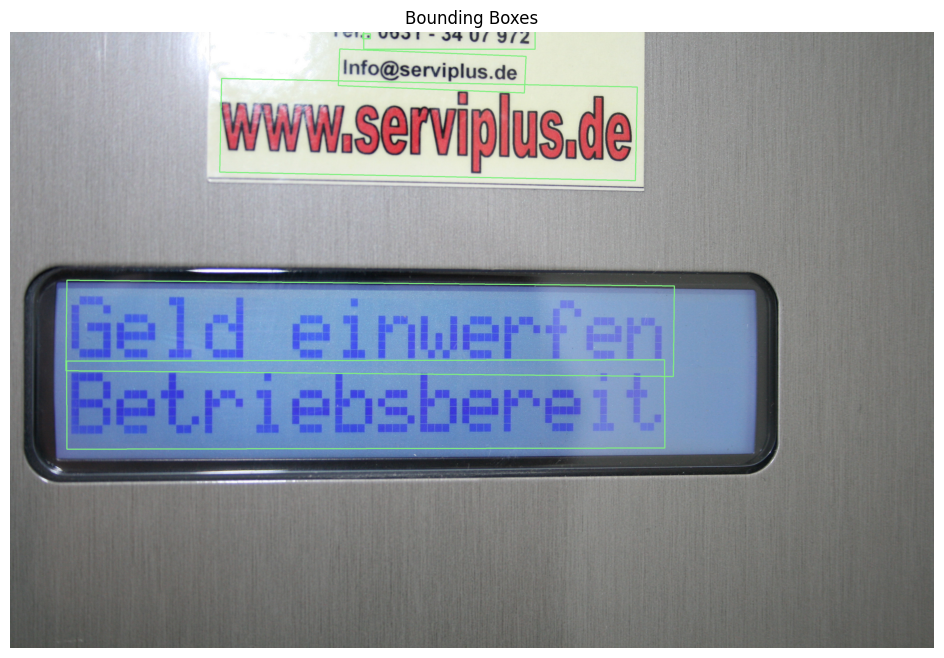

In [13]:
display_image(img_boxes, title="Bounding Boxes")

In [14]:
def crop_and_rotate_image(img, box):
    """Crop the image using the bounding box coordinates."""
    rect = cv2.minAreaRect(box) 
    box = cv2.boxPoints(rect).astype(np.intp)
    width = int(rect[1][0])
    height = int(rect[1][1])
    angle = rect[2]

    src_pts = box.astype("float32")
    dst_pts = np.array([[0, height-1],
                        [0, 0],
                        [width-1, 0],
                        [width-1, height-1]],
                        dtype="float32")

    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    warped = cv2.warpPerspective(img, M, (width, height))
    
    if angle >= 45:
        rotated = cv2.rotate(warped, cv2.ROTATE_90_CLOCKWISE)
    else: 
        rotated = warped
    
    print("width:", rotated.shape[1], "height:", rotated.shape[0])
    
    return rotated

width: 2516 height: 371


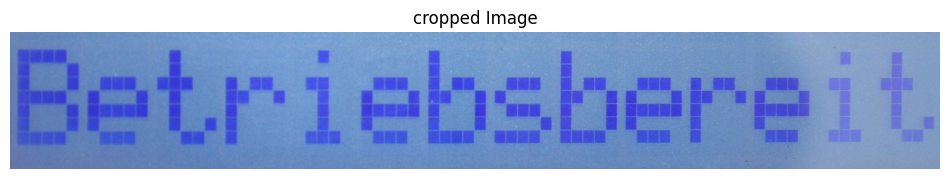

width: 2556 height: 381


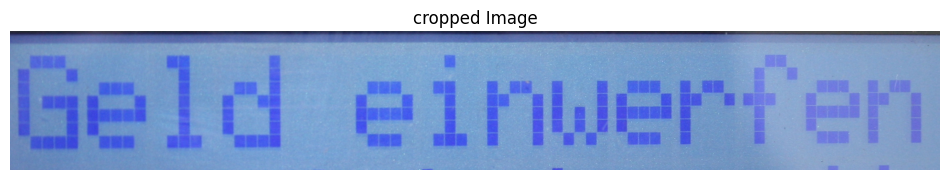

width: 1749 height: 394


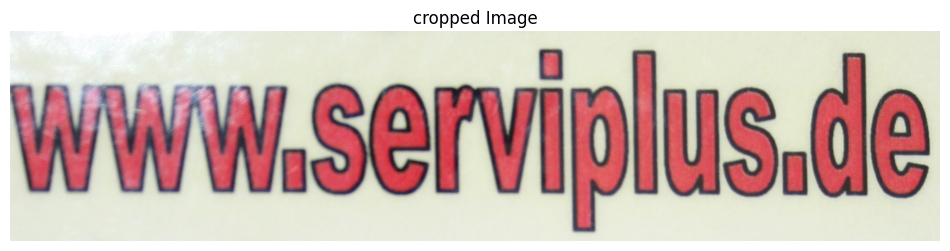

width: 784 height: 154


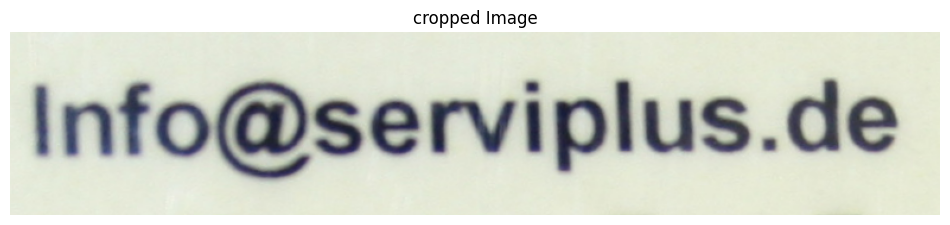

width: 721 height: 85


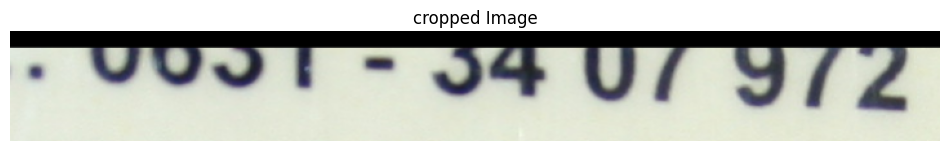

width: 32 height: 21


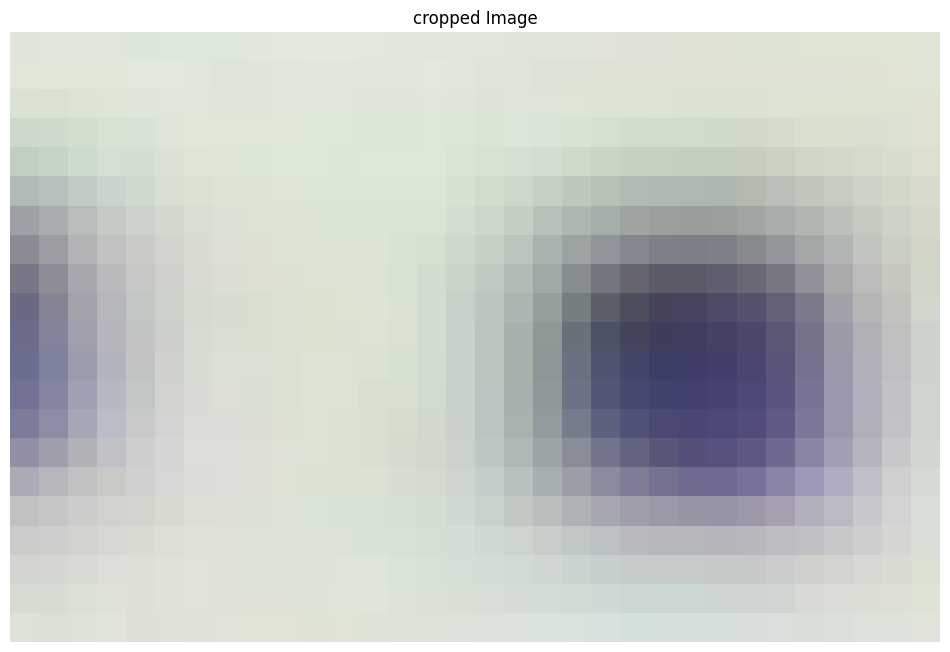

In [15]:
# Recognize text in each detected box
cropped_images = []

for i, box in enumerate(boxes_list):
    cropped_img = crop_and_rotate_image(origin_img, box)  # Crop the image using the bounding box
    cropped_images.append(cropped_img)  # Append the cropped image to the list
    display_image(cropped_img, title="cropped Image")

In [16]:
class strLabelConverter(object):
    """Convert between string and label for OCR tasks.

    Args:
        alphabet (str): Set of possible characters.
        ignore_case (bool, default=True): Whether to ignore case.
    """

    def __init__(self, alphabet, ignore_case=False):
        self._ignore_case = ignore_case
        if self._ignore_case:
            alphabet = alphabet.lower()
        self.alphabet = alphabet + '-'  # for `-1` index

        self.dict = {}
        for i, char in enumerate(alphabet):
            # NOTE: 0 is reserved for 'blank' required by wrap_ctc
            self.dict[char] = i + 1

    def encode(self, text):
        """Encode a string or a list of strings into a sequence of indices.

        Args:
            text (str or list of str): The text(s) to convert.

        Returns:
            np.array: Encoded text as an array of indices.
            np.array: Array of lengths for each text.
        """
        if isinstance(text, str):
            text = [
                self.dict[char.lower() if self._ignore_case else char]
                for char in text
            ]
            length = [len(text)]
        elif isinstance(text, collections.Iterable):
            length = [len(s) for s in text]
            text = ''.join(text)
            text, _ = self.encode(text)
        return (np.array(text, dtype=np.int32), np.array(length, dtype=np.int32))

    def decode(self, t, length, raw=False):
        """Decode a sequence of indices back into a string.

        Args:
            t (np.array): Encoded text as an array of indices.
            length (np.array): Array of lengths for each text.

        Raises:
            AssertionError: If the length of the text and the provided length do not match.

        Returns:
            str or list of str: Decoded text.
        """
        if len(length) == 1:
            length = length[0]
            assert len(t) == length, "text with length: {} does not match declared length: {}".format(t.numel(), length)
            if raw:
                return ''.join([self.alphabet[i - 1] for i in t])
            else:
                char_list = []
                for i in range(length):
                    if t[i] != 0 and (not (i > 0 and t[i - 1] == t[i])):
                        char_list.append(self.alphabet[t[i] - 1])
                return ''.join(char_list)
        else:
            # batch mode
            assert len(t) == length.sum(), "texts with length: {} does not match declared length: {}".format(t.numel(), length.sum())
            texts = []
            index = 0
            for i in range(length.size):
                l = length[i]
                texts.append(
                    self.decode(
                        t[index:index + l], np.array([l]), raw=raw))
                index += l
            return texts

In [17]:
alphabet = """0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~!"#$%&'()*+,-./  """
converter = strLabelConverter(alphabet)

In [18]:
def resize_norm_image(img, input_size):
    image_resized = cv2.resize(img, dsize=(input_size[1], input_size[0]))
    image_resized = (image_resized / 255.0).astype(np.float32)
    input_image = np.zeros((image_resized.shape[0], image_resized.shape[1], 3), dtype=np.float32)
    input_image[:image_resized.shape[0], :image_resized.shape[1], :] = image_resized
    input_image = image_resized[:, :, [2, 1, 0]]  # bgr->rgb
    input_image = input_image[None].transpose(0, 3, 1, 2) # NHWC -> HCHW
    
    return input_image

In [19]:
def rec_predict(input_image, model, output_size):
    model.read_numpy_arr_float32(input_image, 0)
    model.forward(more=True)
        
    # Get the model inference result and reshape it
    preds = model.get_infer_res_np_float32(0).reshape(1, *output_size)
    print("shape:", preds.shape)
        
    # Transpose and get the argmax to obtain final prediction
    preds = np.transpose(preds, (1, 0, 2))
    preds = np.argmax(preds, axis=2)
    preds = preds.transpose(1, 0).reshape(-1)
    preds_size = np.array([preds.size], dtype=np.int32)
    raw_pred = converter.decode(np.array(preds), np.array(preds_size), raw=True)
    sim_pred = converter.decode(np.array(preds), np.array(preds_size), raw=False)
    
    return raw_pred,sim_pred

In [20]:
output_size = (40, 97)
input_size = (48, 320)
recognition_model_path = 'model/en_PP-OCRv3_rec_48x320_rgb.bin'

rec_model = bpu_infer_lib.Infer(False)
if not rec_model.load_model(recognition_model_path):
    raise RuntimeError(f"Failed to load model from '{recognition_model_path}'.")

recognized_texts = []

for i, img in enumerate(cropped_images):
    img = resize_norm_image(img, input_size)
    print(f"Box {i + 1}:")
    raw_pred, sim_pred = rec_predict(img, rec_model, output_size)
    recognized_texts.append(sim_pred)
    print(f"Prediction: {sim_pred} \n")

The model path is valid and points to a regular file.
[A][DNN][packed_model.cpp:247][Model](2024-09-17,07:25:32.410.674) [HorizonRT] The model builder version = 1.23.8
[W][DNN]bpu_model_info.cpp:491][Version](2024-09-17,07:25:32.429.929) Model: en_PP-OCRv3_rec_infer-deploy_48x320_rgb_NCHW. Inconsistency between the hbrt library version 3.15.49.0 and the model build version 3.15.54.0 detected, in order to ensure correct model results, it is recommended to use compilation tools and the BPU SDK from the same OpenExplorer package.
Box 1:
shape: (1, 40, 97)
Prediction: Betriebsbereit 

Box 2:
shape: (1, 40, 97)
Prediction: Geld einwerfen 

Box 3:
shape: (1, 40, 97)
Prediction: wwW.serviplus.de 

Box 4:
shape: (1, 40, 97)
Prediction: Info@serviplus.de 

Box 5:
shape: (1, 40, 97)
Prediction:  005T- 34 07 972 

Box 6:
shape: (1, 40, 97)
Prediction:  



In [21]:
def draw_text_on_image(img, texts, boxes, font_scale=0.7, color=(0, 0, 0), font_thickness=3):
    """Draw recognized texts on a white image based on bounding boxes."""
    for text, box in zip(texts, boxes):
        # Get the center of the bounding box
        center_x = int((box[0][0] + box[2][0]) / 2)
        center_y = int((box[0][1] + box[2][1]) / 2) + 100
        
        # Calculate the size of the text
        (text_width, text_height), baseline = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, font_thickness)
        
        # Calculate the position for the text to center it in the bounding box
        text_x = 0
        text_y = center_y + text_height // 2  # Use bottom of text

        # Draw the text on the image
        cv2.putText(img, text, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, font_thickness)

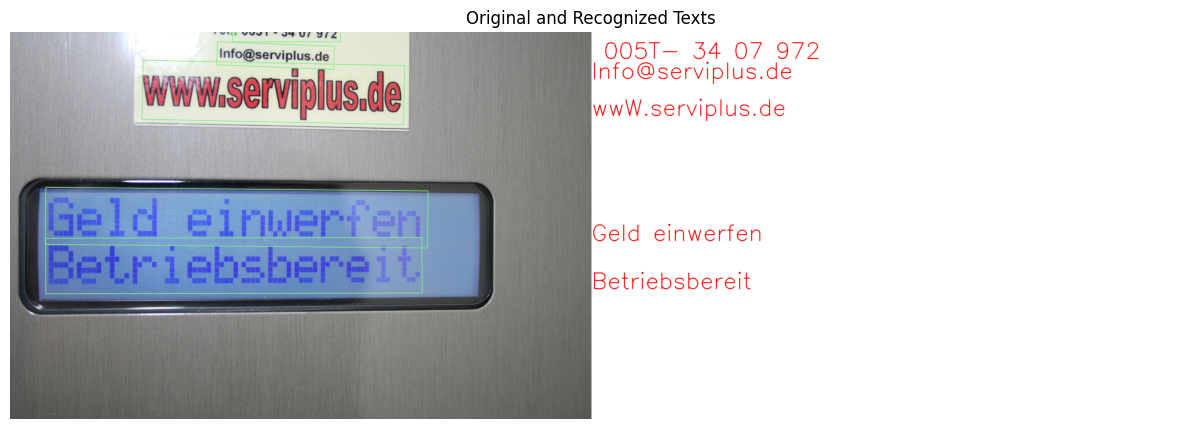

In [22]:
white_image = np.ones(origin_img.shape, dtype=np.uint8) * 255  # create blank image
draw_text_on_image(white_image, recognized_texts, boxes_list, font_scale=5, color=(0, 0, 255), font_thickness=5)  # Red text
combined_image = np.hstack((img_boxes, white_image))    # concate image
display_image(combined_image, title="Original and Recognized Texts", figsize=(15, 10))